# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

In [7]:
cv_store = Path(results_path / 'parameter_tuning.h5')

### Get AlphaLens Input

In [8]:
DATA_DIR = Path('..', 'data')

Using next available prices.

In [9]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'stooq/jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

Reloading predictions.

In [10]:
best_predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('9984.JP', Timestamp('2019-11-29 00:00:00')) to ('1882.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  474264 non-null  float64
 1   0       474264 non-null  float64
 2   1       474264 non-null  float64
 3   2       470500 non-null  float64
 4   3       474264 non-null  float64
 5   4       474264 non-null  float64
 6   5       470500 non-null  float64
 7   6       470500 non-null  float64
 8   7       474264 non-null  float64
 9   8       474264 non-null  float64
 10  9       470500 non-null  float64
dtypes: float64(11)
memory usage: 41.7+ MB


In [11]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()

In [12]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 9984.JP to 1882.JP
dtypes: float64(941)
memory usage: 10.5 MB


In [13]:
factor = (best_predictions
          .iloc[:, :3]
          .mean(1)
          .tz_localize('UTC', level='date')
          .swaplevel()
          .dropna()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker']))

In [14]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC', freq='C'), '1301.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.149771,0.008785,-0.006698,0.006516,91290,20.085676
2,-0.025457,0.012804,-0.001964,0.004145,90808,19.979626
3,-0.021445,0.015681,0.000205,0.004042,90800,19.977866
4,-0.018386,0.019790,0.002430,0.004127,90804,19.978746
5,-0.014789,0.129243,0.007657,0.006926,90801,19.978086


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,57.323,1.176,0.467,0.195
beta,-0.020,-0.035,-0.018,-0.007
Mean Period Wise Return Top Quantile (bps),154.069,29.155,14.324,6.590
Mean Period Wise Return Bottom Quantile (bps),-149.244,-29.194,-14.446,-6.708
Mean Period Wise Spread (bps),303.313,58.355,28.774,13.299


Information Analysis


,1D,5D,10D,21D
IC Mean,0.682,0.287,0.201,0.133
IC Std.,0.089,0.115,0.119,0.116
Risk-Adjusted IC,7.669,2.508,1.695,1.148
t-stat(IC),168.545,55.123,37.261,25.221
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-1.874,-0.190,-0.202,-0.298
IC Kurtosis,9.867,0.672,0.797,0.851


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.784,0.786,0.789,0.786
Quantile 2 Mean Turnover,0.789,0.794,0.796,0.794
Quantile 3 Mean Turnover,0.778,0.787,0.790,0.790
Quantile 4 Mean Turnover,0.794,0.793,0.798,0.796
Quantile 5 Mean Turnover,0.774,0.785,0.786,0.785


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.017,-0.007,-0.007,0.001


<Figure size 640x480 with 0 Axes>

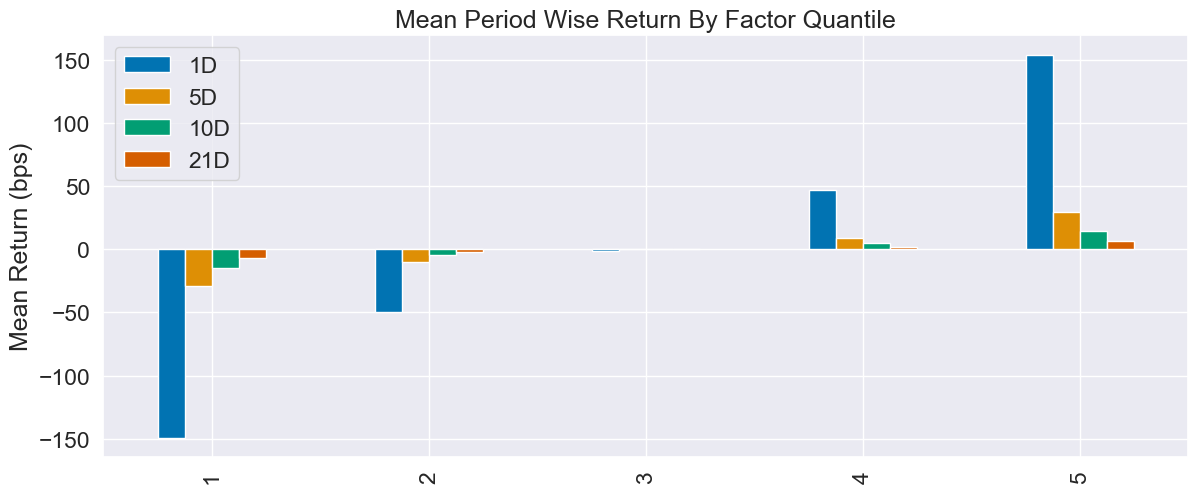

In [15]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [16]:
t = 1
predictions = pd.read_hdf(results_path / 'predictions.h5',
                          f'test/{t:02}').drop('y_test', axis=1)

In [17]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('9984.JP', Timestamp('2019-11-29 00:00:00')) to ('1882.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       470500 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       470500 non-null  float64
 6   6       470500 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       470500 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB


In [18]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2017-12-05 00:00:00+00:00  1301.JP    0.000682
2017-12-06 00:00:00+00:00  1301.JP    0.000570
2017-12-07 00:00:00+00:00  1301.JP    0.000562
2017-12-08 00:00:00+00:00  1301.JP    0.000705
2017-12-11 00:00:00+00:00  1301.JP    0.002467
dtype: float64

### Select next available trade prices

Using next available prices.

In [19]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1301.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB


### Get AlphaLens Inputs

In [20]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC', freq='C'), '1301.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.033712,0.012796,-0.001750,0.004278,91309,20.089856
2,-0.027564,0.012920,-0.000909,0.003816,90793,19.976326
3,-0.027001,0.015197,-0.000396,0.003683,90803,19.978526
4,-0.026620,0.016081,0.000158,0.003650,90794,19.976546
5,-0.026170,0.029528,0.001212,0.003942,90804,19.978746


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.051,0.040,0.032,0.019
beta,0.063,0.047,0.035,0.044
Mean Period Wise Return Top Quantile (bps),3.339,2.420,1.973,1.080
Mean Period Wise Return Bottom Quantile (bps),-1.638,-1.348,-0.918,-0.596
Mean Period Wise Spread (bps),4.977,3.764,2.889,1.670


Information Analysis


,1D,5D,10D,21D
IC Mean,0.010,0.017,0.018,0.012
IC Std.,0.101,0.104,0.098,0.106
Risk-Adjusted IC,0.096,0.161,0.187,0.115
t-stat(IC),2.116,3.532,4.100,2.536
p-value(IC),0.035,0.000,0.000,0.012
IC Skew,0.328,0.262,0.287,0.604
IC Kurtosis,1.673,0.740,0.614,1.172


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.682,0.753,0.778,0.794
Quantile 2 Mean Turnover,0.758,0.784,0.790,0.797
Quantile 3 Mean Turnover,0.764,0.789,0.791,0.798
Quantile 4 Mean Turnover,0.761,0.785,0.790,0.800
Quantile 5 Mean Turnover,0.649,0.713,0.751,0.779


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.23,0.125,0.065,0.016


<Figure size 640x480 with 0 Axes>

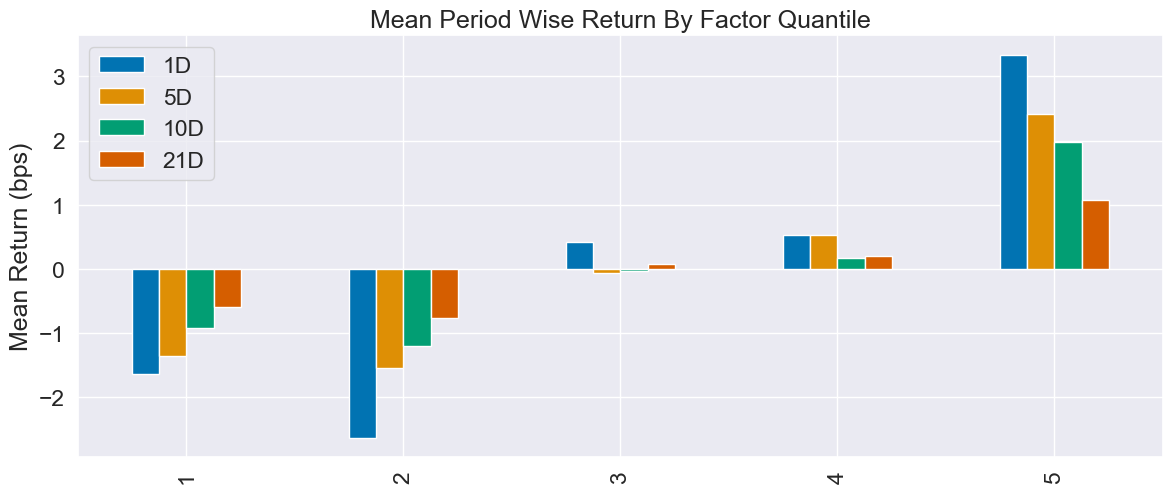

In [21]:
create_summary_tear_sheet(factor_data)